# KNN classification Algorithm
----




In [3]:
#loading package needed
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [61]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "data/cleveland.csv")

heart_disease_data <- read_csv("data/cleveland.csv", col_names = FALSE) |>
                       rename( age = X1,
                               sex = X2,
                               cp = X3,
                               trestbps = X4,
                               chol = X5,
                               fbs = X6,
                               restecg = X7,
                              thalach = X8,
                              exang =  X9, 
                             oldpeak =  X10,
                             slope =  X11, 
                             ca = X12,
                             thal= X13,
                              num = X14)

heart_disease_data <- mutate(heart_disease_data, new_num = case_when(num == 0 ~ 0,
                                                                     num == 1| num == 2 | num == 3| num == 4 ~ 1))
heart_disease_data <- mutate(heart_disease_data, sex = case_when(sex == 0 ~ "male",sex == 1 ~ "female")) |> 
                      mutate(thal = as.numeric(thal),new_num = as.factor(new_num))
heart_disease_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,new_num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,female,1,145,233,1,2,150,0,2.3,3,0.0,6,0,0
67,female,4,160,286,0,2,108,1,1.5,2,3.0,3,2,1
67,female,4,120,229,0,2,129,1,2.6,2,2.0,7,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,female,4,130,131,0,0,115,1,1.2,2,1.0,7,3,1
57,male,2,130,236,0,2,174,0,0.0,2,1.0,3,1,1
38,female,3,138,175,0,0,173,0,0.0,1,?,3,0,0


In [62]:
#split data
set.seed(1231)
hd_split <- initial_split(heart_disease_data, prop = 0.75, strata = new_num)  
hd_train <- training(hd_split)   
hd_test <- testing(hd_split)


(row_with_question <- hd_train |> 
                    filter(thal == "?" | ca == "?"))
## Noted that there is 3 row with "?" in variable thal, which means they dont have measurement of the thal 
## We should filter out those 3 row in our traning Set 
hd_train <- hd_train |> 
            filter(thal != "?") |> 
            filter(ca != "?")

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,new_num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
52,female,3,138,223,0,0,169,0,0.0,1,?,3,0,0
58,female,2,125,220,0,0,144,0,0.4,2,?,7,0,0
43,female,4,132,247,1,2,143,1,0.1,2,?,7,1,1


In [63]:
#recipe with data removed fbs, restecg, ca columns
set.seed(999) 
hd_train <-  hd_train |> 
            mutate(thal = as.numeric(thal),
            new_num = as.factor(new_num)) 
#change all the columns to numerical, and class to factor

hd_train

knn_recipe <- recipe(new_num ~ age + cp + trestbps + chol + thalach + exang+ oldpeak + slope + thal,
                    data = hd_train_shorten) |>
    step_center(all_predictors()) |>
    step_scale (all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |>
set_mode("classification") 
 # -fbs, -restecg,-ca,-sex, -num    

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,new_num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
41,male,2,130,204,0,2,172,0,1.4,1,0.0,3,0,0
57,female,4,140,192,0,0,148,0,0.4,2,0.0,6,0,0
56,male,2,140,294,0,2,153,0,1.3,2,0.0,3,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,female,1,110,264,0,0,132,0,1.2,2,0.0,7,1,1
68,female,4,144,193,1,0,141,0,3.4,2,2.0,7,2,1
57,female,4,130,131,0,0,115,1,1.2,2,1.0,7,3,1


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.8158586,5,0.02965279,Preprocessor1_Model09
10,accuracy,binary,0.8158586,5,0.02965279,Preprocessor1_Model10
11,accuracy,binary,0.8157576,5,0.02807572,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4,accuracy,binary,0.7525253,5,0.02047231,Preprocessor1_Model04
1,accuracy,binary,0.7027273,5,0.01936893,Preprocessor1_Model01
2,accuracy,binary,0.7027273,5,0.01936893,Preprocessor1_Model02


[1] "Table 13. Cross model Model Estimated Accuracies for K = 1 to 12"


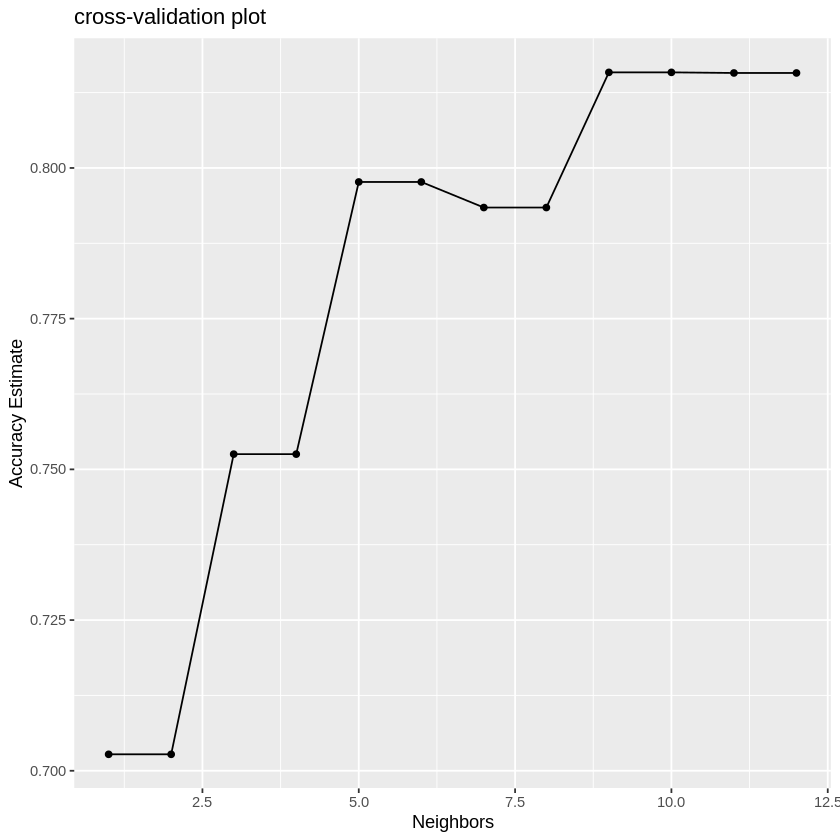

In [64]:
set.seed(1231) 
knn_vfold <- vfold_cv(hd_train, v = 5, strata = new_num)
gridvals <- tibble(neighbors = seq(from = 1, to =12))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = knn_vfold, grid = gridvals) |>
  collect_metrics() 

accuracies <- knn_results |> 
       filter(.metric == "accuracy") |>
       arrange(desc(mean))
accuracies

print("Table 13. Cross model Model Estimated Accuracies for K = 1 to 12")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("cross-validation plot")
cross_val_plot

We are choosing **K = 10** as our final model

Then we are creating the final model 

In [65]:
 # -fbs, -restecg,-ca,-sex, -num
#Create final model with K = 7
set.seed(1231)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
set_engine("kknn") |>
set_mode("classification")

knn_fit <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec) |>
fit(data = hd_train)

In [66]:
#testing model predictions with testing set

set.seed(1231) #ensuring reproducibility

test_predictions <- predict(knn_fit,hd_test) |>
bind_cols(hd_test)
test_predictions 


knn_metrics <- test_predictions |>
metrics(truth = new_num, estimate = .pred_class)
knn_metrics

print("Table 14. KNN metrics")

#accuracy seems unaffected when applying model to testing dataset

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,new_num
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
0,63,female,1,145,233,1,2,150,0,2.3,3,0.0,6,0,0
0,37,female,3,130,250,0,0,187,0,3.5,3,0.0,3,0,0
0,56,female,2,120,236,0,0,178,0,0.8,1,0.0,3,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,41,female,2,120,157,0,0,182,0,0,1,0.0,3,0,0
0,57,male,2,130,236,0,2,174,0,0,2,1.0,3,1,1
0,38,female,3,138,175,0,0,173,0,0,1,?,3,0,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8552632
kap,binary,0.7081006


[1] "Table 14. KNN metrics"


Our final model have accaruy of 0.85 on the test model. 